## Assignment 1

**Submission deadlines:** 
- get at least **2** points by Tuesday, 9.03.2021
- remaining points: last lab session before or on Tuesday, 16.03.2021

**Points:** Aim to get 8 out of 12 possible points

## Submission instructions
The class is held remotely. To sumbmit your solutions please show the notebook over the video call. Make sure you know all the questions and asnwers, and that the notebook contains results (before presentation do `Runtime -> Restar and run all`)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Task description

## TLDR
Implement and train a neural network using pure numpy.


## Problem 1 [2p]
Implement a two-layer network, manually set weights and biases to solve the XOR task.

A two-layer neural network implementes a function $f: \mathbb{R}^D \rightarrow \mathbb{R}^O$ where $D$ is the input dimensionality and $O$ is the output dinemsionality. The output goes through an intermediate representation (the hidden layer) with dimensionality $H$. 

The computations are as follows:
\begin{equation}
\begin{split}
A_1 &= x W_1^T + b_1  & \qquad\text{Total input to neurons in the hidden layer (network's first layer)} \\
O_1 &= \sigma_1(A_1)  & \qquad\text{Output of the hidden layer} \\
A_2 &= O_1 W_2^T + b_2 & \qquad\text{Total input to neurons in the output layer (network's second layer)}\\
O_2 &= \sigma_2(A_2) & \qquad\text{Output of the network}
\end{split}
\end{equation}

Where $W$ are weight matrices, $b$ are bias vectors, $\sigma$ are non-linear activation functions (e.g. the logistic sigmoid applied element-wise, or softmax).

For the 2D xor problem the network will:
- have 2 inputs, 2 hidden neurons, one output
- use the logistic sigmoid everywhere (that way we, when hand-designig the weights, we can assume that neurons' outputs are binary).

Therrefore the shapes of the data floing through the network will be:
- input: $x\in\mathbb{}R^{2}$
- hidden layer parameters: $W_1\in\mathbb{}R^{2\times 2}$ and $b_1\in\mathbb{}R^{2}$
- representations in the hidden layer: $A_1\in\mathbb{}R^{2}$ and $O_1\in\mathbb{}R^{2}$
- output layer parameters: $W_2\in\mathbb{}R^{1\times 2}$ and $b_1\in\mathbb{}R^{1}$
- representations in the output layer: $A_2\in\mathbb{}R^{1}$ and $O_2\in\mathbb{}R^{1}$

The network can be seen as a logistic regression model, prefixed by a nonlinear transformation of the data.

The first tasks consists of:
- implementing the network
- selecting parametwrs ($W_1, b_1, W_2, b_2$) such that $f(x)\approx XOR(x_1, x_2)$ where the approximation is die to the sigmoids - the output may be close to 0 or 1, but doesn't need to saturate at 0 or 1.

NB: the convention on weight matrix shapes follows linear [layers in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).


## Problem 2 [2p]
1. Add a backward pass.
2. Use a sensible random initialization for weights and biases.
3. Numerically check the correctness of your gradient computation.

There is nice article about taking derivative over vectors and vector chain rule: https://explained.ai/matrix-calculus/ if someone don't have experience with suchr calculus.


## Problem 3 [2p]
1. Implement gradient descent
2. Train your network to solve 3D XOR
3. Try several hidden layer sizes, for each size record the fracton of successful trainings. Then answer:
    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    - What is the minimal hidden size required to reliably solve 3D XOR
    - Which networks are easier to train - small or large ones? Why?


## Problem 4 [1p]
Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Find a network architecture which reliably learns the 3D XOR problem.


## Problem 5 [1p]
Add a second hidden layer to your network, implement the forward and backward pass, then demonstrate training.


## Problem 6 [2p]
Implement a way to have a _variable number_ of hidden layers. Check how deep sigmoid or ReLU networks you  can train. For simplicity you can assume that all hidden layers have the same number of neurons, and use the same activation function.


## Problem 7 [2p]
For each weight matrix $w\in\mathbb{R}^{n\times m}$, add a randomly initialized `backward weight` $w_b\in\mathbb{R}^{m\times n}$, which will not change during training. Change the backward pass to use $w_b$ instead of $w^T$, getting an approxmatoin of the true gradient. Can you get your network to train?

NB: this approach, dubbed [feedback alignment](https://www.nature.com/articles/ncomms13276), was proposed to make error backpropagation more biologically plausible, by providing a solution to the "weight transport problem". Regular backpropagation requires that neurons not only know their incoming weights (thet they control), but also their outgoing weights (that are controlled by neurons in the upper layers). This is nearly impossible in a real brain.

# Solutions and starter code

In [1]:
import matplotlib.pyplot as plt
import numpy as np

XOR dataset creation

(-0.05, 1.05, -0.05, 1.05)

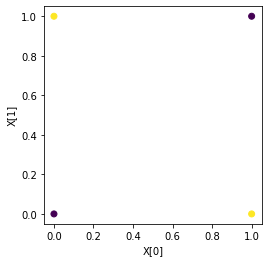

In [2]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1],], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array([[0], [1], [1], [0],], dtype=np.float32)

plt.scatter(
    X[:, 0], X[:, 1], c=Y[:, 0],
)
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.axis("square")

## Problem 1

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D$ matrix.

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params(in_features, num_hidden)

    def init_params(self, in_features, num_hidden):
        # TODO for Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.normal(0, 0.5, (num_hidden, in_features))
        self.b1 = np.random.normal(0, 0.5, (num_hidden,))
        self.W2 = np.random.normal(0, 0.5, (1, num_hidden))
        self.b2 = np.random.normal(0, 0.5, (1,))

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = np.dot(X, self.W1.T) + self.b1
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)
        # Inputs to neuron in the second layer
        A2 = np.dot(O1, self.W2.T) + self.b2
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2:
            # fill in the gradient computation
            # Please note, that there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reverse order.
            # We save the gradients with respect to the parameters as fields of self.
            # It is not very elegant, but simplifies training code later on.

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient
            # of logistic sigmoid and cross-entropy loss
            A2_grad = O2 - Y
            self.b2_grad = A2_grad.sum(0) / X.shape[0]
            self.W2_grad = np.dot(A2_grad.T, O1) / X.shape[0]
            O1_grad = np.dot(A2_grad, self.W2)
            A1_grad = O1_grad * O1 * (1 - O1)
            self.b1_grad = A1_grad.sum(0) / X.shape[0]
            self.W1_grad = np.dot(A1_grad.T, X) / X.shape[0]

        return O2, loss

In [4]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([10, 10, 10, 10]).reshape(2,2)
net.b1 = np.array([-5, -15])
net.W2 = np.array([10, -10]).reshape(1,2)
net.b2 = np.array([-5])

# Hint: since we use the logistic sigmoid activation, the weights may need to
# be fairly large


predictions, loss = net.forward(X, Y, do_backward=False)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 0.0071527881888964915
XORnet([0. 1.]) = 0.9923558641717396
XORnet([1. 0.]) = 0.9923558641717396
XORnet([1. 1.]) = 0.0071527881888964785


## Problem 2

In [5]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + "_grad")
    assert param.shape == orig_grad.shape

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [6]:
# Hint: use float64 for checking the correctness of the gradient
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ["W1", "b1", "W2", "b2"]:
    check_grad(net, param_name, X, Y)

## Problem 3

In [7]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 0.1  # set a learning rate

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(f"after {i} steps \tloss={loss}")
    for param_name in ["W1", "b1", "W2", "b2"]:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        # alternatively, you could do setattr(net, param_name, new_value)
        param[:] = param - alpha * getattr(net, param_name + "_grad")

after 0 steps 	loss=0.7489294913541362
after 5000 steps 	loss=0.03223397796724391
after 10000 steps 	loss=0.009739279710994149
after 15000 steps 	loss=0.005567371455285882
after 20000 steps 	loss=0.0038628618589463615
after 25000 steps 	loss=0.002944685023797385
after 30000 steps 	loss=0.00237312963562205
after 35000 steps 	loss=0.0019840355916228903
after 40000 steps 	loss=0.001702502952511916
after 45000 steps 	loss=0.0014895818216626726
after 50000 steps 	loss=0.0013230506438688225
after 55000 steps 	loss=0.0011893218311937951
after 60000 steps 	loss=0.0010796270915850285
after 65000 steps 	loss=0.0009880585969089578
after 70000 steps 	loss=0.000910492572007852
after 75000 steps 	loss=0.0008439643367936262
after 80000 steps 	loss=0.0007862885327519537
after 85000 steps 	loss=0.0007358192996987094
after 90000 steps 	loss=0.0006912937703061641
after 95000 steps 	loss=0.0006517269913501864


In [8]:
predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 0.00025420069745527306
XORnet([0. 1.]) = 0.9991345011467168
XORnet([1. 0.]) = 0.9995843419687509
XORnet([1. 1.]) = 0.0009290754683234042


In [12]:
# TODO:
# Generate data for a 3D XOR task
# Then estimate the success rate of training the network with diferent
# hidden sizes.

X3 = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]], dtype=np.float32)
Y3 = np.array([[0], [1], [1], [0], [1], [0], [0], [1]], dtype=np.float32)

for hidden_dim in [2, 3, 5, 10, 20]:
    # TODO: run a few trainings and record the fraction of successful ones
    print(f"for hidden_dim {hidden_dim}\n")
    for _ in range(3):
      net = SmallNet(3, hidden_dim, dtype=np.float64)

      alpha = 0.1

      for i in range(100000):
        _, loss = net.forward(X3, Y3, do_backward=True)
        for param_name in ["W1", "b1", "W2", "b2"]:
          param = getattr(net, param_name)
          param[:] = param - alpha * getattr(net, param_name + "_grad")
      
      predictions, loss = net.forward(X3, Y3, do_backward=True)
      for x, p in zip(X3, predictions):
          print(f"3DXORnet({x}) = {p[0]}")
      print("\n")

for hidden_dim 2

3DXORnet([0. 0. 0.]) = 0.0010843920932214377
3DXORnet([0. 0. 1.]) = 0.4992046621019881
3DXORnet([0. 1. 0.]) = 0.4991312818168478
3DXORnet([0. 1. 1.]) = 0.0010244599113976086
3DXORnet([1. 0. 0.]) = 0.9990151560193268
3DXORnet([1. 0. 1.]) = 0.5003706088271567
3DXORnet([1. 1. 0.]) = 0.5002730794542105
3DXORnet([1. 1. 1.]) = 0.9989597328543135


3DXORnet([0. 0. 0.]) = 0.009109819024244858
3DXORnet([0. 0. 1.]) = 0.9904568761927193
3DXORnet([0. 1. 0.]) = 0.9777790973040723
3DXORnet([0. 1. 1.]) = 0.00910071168534801
3DXORnet([1. 0. 0.]) = 0.9904568752473433
3DXORnet([1. 0. 1.]) = 0.025246078786940854
3DXORnet([1. 1. 0.]) = 0.009100711983556187
3DXORnet([1. 1. 1.]) = 0.9904865082378425


3DXORnet([0. 0. 0.]) = 0.026815167640886463
3DXORnet([0. 0. 1.]) = 0.944348772536638
3DXORnet([0. 1. 0.]) = 0.9690922593410612
3DXORnet([0. 1. 1.]) = 0.026767780007317162
3DXORnet([1. 0. 0.]) = 0.9690922591285699
3DXORnet([1. 0. 1.]) = 0.026767780082256335
3DXORnet([1. 1. 0.]) = 0.08182750327

- What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
 - The minimal hidden size required to solve 3D XOR is 2.
- What is the minimal hidden size required to reliably solve 3D XOR
 - The minimal hidden size required to reliably solve 3D XOR is 3.
- Which networks are easier to train - small or large ones? Why?
 - Large networks are easier to train because it is easier to tune in parameters when exploring more combinations.

## Problem 4


In [13]:
def rectifier(x):
  return np.where(x >= 0, x, 0)

class SmallNet2:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params(in_features, num_hidden)

    def init_params(self, in_features, num_hidden):
        self.W1 = np.random.normal(0, 0.5, (num_hidden, in_features))
        self.b1 = np.random.normal(0, 0.5, (num_hidden,))
        self.W2 = np.random.normal(0, 0.5, (1, num_hidden))
        self.b2 = np.random.normal(0, 0.5, (1,))

    def forward(self, X, Y=None, do_backward=False):
        A1 = np.dot(X, self.W1.T) + self.b1
        O1 = rectifier(A1)
        A2 = np.dot(O1, self.W2.T) + self.b2
        O2 = sigmoid(A2)

        if Y is not None:
            loss = -Y * np.log(O2) - (1 - Y) * np.log(1.0 - O2)
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            A2_grad = O2 - Y
            self.b2_grad = A2_grad.sum(0) / X.shape[0]
            self.W2_grad = np.dot(A2_grad.T, O1) / X.shape[0]
            O1_grad = np.dot(A2_grad, self.W2)
            A1_grad = O1_grad * np.where(A1 >= 0, 1, 0)
            self.b1_grad = A1_grad.sum(0) / X.shape[0]
            self.W1_grad = np.dot(A1_grad.T, X) / X.shape[0]

        return O2, loss

In [17]:
for _ in range(10):
  net = SmallNet2(3, 12, dtype=np.float64)

  alpha = 0.1

  for i in range(100000):
    _, loss = net.forward(X3, Y3, do_backward=True)
    for param_name in ["W1", "b1", "W2", "b2"]:
      param = getattr(net, param_name)
      param[:] = param - alpha * getattr(net, param_name + "_grad")
      
  predictions, loss = net.forward(X3, Y3, do_backward=True)
  for x, p in zip(X3, predictions):
      print(f"3DXORnet({x}) = {p[0]}")
  print("\n")

3DXORnet([0. 0. 0.]) = 8.314645972931567e-05
3DXORnet([0. 0. 1.]) = 0.9999124555315769
3DXORnet([0. 1. 0.]) = 0.9999187094633829
3DXORnet([0. 1. 1.]) = 4.839643695274793e-05
3DXORnet([1. 0. 0.]) = 0.999775183798753
3DXORnet([1. 0. 1.]) = 0.00019419092691546307
3DXORnet([1. 1. 0.]) = 0.0001338681256426438
3DXORnet([1. 1. 1.]) = 0.9998700055446894


3DXORnet([0. 0. 0.]) = 0.00011639498211921722
3DXORnet([0. 0. 1.]) = 0.999971702073183
3DXORnet([0. 1. 0.]) = 0.9997553627740731
3DXORnet([0. 1. 1.]) = 0.00014332851579986947
3DXORnet([1. 0. 0.]) = 0.9997544806714079
3DXORnet([1. 0. 1.]) = 0.00014409576913095902
3DXORnet([1. 1. 0.]) = 0.0003229654638829332
3DXORnet([1. 1. 1.]) = 0.9997497884074039


3DXORnet([0. 0. 0.]) = 7.616684934318005e-05
3DXORnet([0. 0. 1.]) = 0.9998989877239454
3DXORnet([0. 1. 0.]) = 0.9999129376889186
3DXORnet([0. 1. 1.]) = 7.818393903414217e-05
3DXORnet([1. 0. 0.]) = 0.9998591379138274
3DXORnet([1. 0. 1.]) = 0.00010511808842143507
3DXORnet([1. 1. 0.]) = 0.00011701256

## Problem 5

In [64]:
class SmallNet3:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((num_hidden, num_hidden), dtype=dtype)
        self.b2 = np.zeros((num_hidden,), dtype=dtype)
        self.W3 = np.zeros((1, num_hidden), dtype=dtype)
        self.b3 = np.zeros((1,), dtype=dtype)
        self.init_params(in_features, num_hidden)

    def init_params(self, in_features, num_hidden):
        self.W1 = np.random.normal(0, 0.5, (num_hidden, in_features))
        self.b1 = np.random.normal(0, 0.5, (num_hidden,))
        self.W2 = np.random.normal(0, 0.5, (num_hidden, num_hidden))
        self.b2 = np.random.normal(0, 0.5, (num_hidden,))
        self.W3 = np.random.normal(0, 0.5, (1, num_hidden))
        self.b3 = np.random.normal(0, 0.5, (1,))

    def forward(self, X, Y=None, do_backward=False):
        A1 = np.dot(X, self.W1.T) + self.b1
        O1 = sigmoid(A1)
        A2 = np.dot(O1, self.W2.T) + self.b2
        O2 = sigmoid(A2)
        A3 = np.dot(O2, self.W3.T) + self.b3
        O3 = sigmoid(A3)

        if Y is not None:
            loss = -Y * np.log(O3) - (1 - Y) * np.log(1.0 - O3)
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            A3_grad = O3 - Y
            self.b3_grad = A3_grad.sum(0) / X.shape[0]
            self.W3_grad = np.dot(A3_grad.T, O2) / X.shape[0]
            O2_grad = np.dot(A3_grad, self.W3)

            A2_grad = O2_grad * O2 * (1 - O2)
            self.b2_grad = A2_grad.sum(0) / X.shape[0]
            self.W2_grad = np.dot(A2_grad.T, O1) / X.shape[0]
            O1_grad = np.dot(A2_grad, self.W2)

            A1_grad = O1_grad * O1 * (1 - O1)
            self.b1_grad = A1_grad.sum(0) / X.shape[0]
            self.W1_grad = np.dot(A1_grad.T, X) / X.shape[0]

        return O3, loss

In [62]:
net = SmallNet3(3, 2, dtype=np.float64)

for param_name in ["W1", "b1", "W2", "b2", "W3", "b3"]:
    check_grad(net, param_name, X3, Y3)

In [65]:
for hidden_dim in [3, 5, 10, 20]:
    print(f"for hidden_dim {hidden_dim}\n")
    for _ in range(3):
      net = SmallNet3(3, hidden_dim, dtype=np.float64)

      alpha = 0.2

      for i in range(100000):
        _, loss = net.forward(X3, Y3, do_backward=True)
        for param_name in ["W1", "b1", "W2", "b2", "W3", "b3"]:
          param = getattr(net, param_name)
          param[:] = param - alpha * getattr(net, param_name + "_grad")
      
      predictions, loss = net.forward(X3, Y3, do_backward=True)
      for x, p in zip(X3, predictions):
          print(f"3DXORnet({x}) = {p[0]}")
      print("\n")

for hidden_dim 3

3DXORnet([0. 0. 0.]) = 6.392388490752066e-05
3DXORnet([0. 0. 1.]) = 0.9998906950028245
3DXORnet([0. 1. 0.]) = 0.999860183847425
3DXORnet([0. 1. 1.]) = 0.00015543934845865508
3DXORnet([1. 0. 0.]) = 0.999846668186131
3DXORnet([1. 0. 1.]) = 0.0001479524075812217
3DXORnet([1. 1. 0.]) = 0.00011796194853949878
3DXORnet([1. 1. 1.]) = 0.9999669994851064


3DXORnet([0. 0. 0.]) = 7.561036552550823e-05
3DXORnet([0. 0. 1.]) = 0.9998456539543505
3DXORnet([0. 1. 0.]) = 0.9998504313597206
3DXORnet([0. 1. 1.]) = 0.00016908444814322772
3DXORnet([1. 0. 0.]) = 0.9998795040004919
3DXORnet([1. 0. 1.]) = 0.000187353373731129
3DXORnet([1. 1. 0.]) = 0.00019181469045222814
3DXORnet([1. 1. 1.]) = 0.9999825650555618


3DXORnet([0. 0. 0.]) = 0.00017160171291651685
3DXORnet([0. 0. 1.]) = 0.9998810956194475
3DXORnet([0. 1. 0.]) = 0.999882991589447
3DXORnet([0. 1. 1.]) = 0.00017307939211891644
3DXORnet([1. 0. 0.]) = 0.9998308102442762
3DXORnet([1. 0. 1.]) = 9.895047500690044e-05
3DXORnet([1. 1. 0.]

## Problem 6

## Problem 7